We compare three implementations of the same Algorithm: calculating $\pi$ by Monte Carlo method
- Serial
- multiprocessing
- ipyparallel

## Serial solution

In [1]:
from random import uniform
from time import time

In [2]:
def sample_circle(n):
    """
    throw n darts in [0, 1] * [0, 1] square, return the number
    of darts inside unit circle.
    
    Parameter
    ---------
        n: number of darts to throw.
    
    Return
    ------
        m: number of darts inside unit circle.
    """
    m = 0
    for i in range(int(n)):
        x, y = uniform(0, 1), uniform(0, 1)
        if x**2 + y**2 < 1:
            m += 1
    return m

In [3]:
def pi_serial(n):
    """
    Naive serial implementation of monte carlo pi using 
        sample_circle function.
        
    Parameter
    ---------
        n: number of darts to throw
    
    Return
    ------
        value of pi in the monte-carlo simulation
    """
    t1 = time()
    m = sample_circle(n)
    t2 = time()
    t_loop = t2 - t1
    
    pi_approx = 4. * m / n
    return pi_approx, t_loop

In [4]:
n = 100000
%time pi_serial(n)

CPU times: user 124 ms, sys: 5.29 ms, total: 129 ms
Wall time: 126 ms


(3.14564, 0.12616705894470215)

## Multiprocessing implementation

In [5]:
from random import uniform
from multiprocessing import Pool 
from time import time

In [6]:
def sample_circle(n):
    """
    throw n darts in [0, 1] * [0, 1] square, return the number
    of darts inside unit circle.
    
    Parameter
    ---------
        n: number of darts to throw.
    
    Return
    ------
        m: number of darts inside unit circle.
    """
    m = 0
    for i in range(int(n)):
        x, y = uniform(0, 1), uniform(0, 1)
        if x**2 + y**2 < 1:
            m += 1
    return m

In [28]:
def pi_mp(num_darts, num_proc=None, msg = False):
    """
    Calculate pi using multiprocessing
    
    Parameter
    ---------
    num_darts: total number of darts to throw to calculate pi
    num_proc: number of processors/ workers to assign, default
            value = os.cpu_count()
    
    Return
    ------
        pi_approx: approximated value of pi
        t_loop: time spent in monte carlo simulation in seconds.
            initializing and shutting down worker pool have been
            excluded in timing. 
    """
    # default number processes = num of CPUs
    if not num_proc:
        import os
        num_proc = os.cpu_count()    
    
    t1 = time()
    
    # average number of darts that each processor process
    
    avg_load = num_darts // num_proc
    extra_load = num_darts % avg_load
    
    # initialize workload for processors
    
    loads = [avg_load] * num_proc
    loads[num_proc - 1] += extra_load
    
    # start a pool of workers
    pool = Pool(processes=num_proc)

    t2 = time()
    
    # assign jobs for each worker
    result = pool.imap_unordered(sample_circle, loads)
    # combine results from all workers
    num_in_cirlce = sum(result)
    
    t3 = time()
    
    # shut down pool, remove pointer to pool object
    # allowing garbage collectors release memory
    pool.terminate()
    del pool
    
    t4 = time()
    
    t_setup = t2-t1
    t_loop = t3-t2
    t_shutdown = t4-t3
    pi_approx = 4 *  num_in_cirlce / num_darts
    
    if msg:
        print("set up {0} workers used {1:.3g}s".format(num_proc, t_setup))
        print("throwing {0} darts used {1:.3g}s".format(num_darts, t_loop))
        print("terminate {0} workers used {1:.3g}s".format(num_proc, t_shutdown))
    return pi_approx, t_loop

In [8]:
num_darts = 100000
pi_mp(num_darts)

set up 4 workers used 0.0831s
throwing 100000 darts used 0.06s
terminate 4 workers used 0.0459s


(3.1458, 0.06000494956970215)

## ipyparallel implementation

First start ipython cluster in terminal
<center> $ipcluster start -n 4 </center>


In [9]:
def sample_circle(n):
    """
    throw n darts in [0, 1] * [0, 1] square, return the number
    of darts inside unit circle.
    
    Parameter
    ---------
        n: number of darts to throw.
    
    Return
    ------
        m: number of darts inside unit circle.
    """
    m = 0
    for i in range(int(n)):
        x, y = uniform(0, 1), uniform(0, 1)
        if x**2 + y**2 < 1:
            m += 1
    return m

In [10]:
from ipyparallel import Client
from time import time

In [31]:
def pi_ipp(dview, num_darts, msg=False):
    """
    Calculate pi using ipyparallel module
    
    Parameter
    ---------
    num_darts: total number of darts to throw to calculate pi
    num_proc: number of processors/ workers to assign, default
            value = os.cpu_count()
    
    Return
    ------
        pi_approx: approximated value of pi
        t_loop: time spent in monte carlo simulation in seconds.
            initializing ipyparallel client has been
            excluded in timing.     
    """
    t1 = time()

    with dview.sync_imports():
        from random import uniform
        
    num_proc = len(clients.ids)
    avg_load = num_darts // num_proc
    extra_load = num_darts % avg_load
    
    # initialize workload for processors
    loads = [avg_load] * num_proc
    loads[num_proc - 1] += extra_load
        
    t2 = time()
    
    result = dview.map_async(sample_circle, loads)   
    approx_pi = 4 * sum(result) / num_darts
    t3 = time() 
    
    t_loop = t3 - t2
    t_setup = t2 - t1
    
    if msg:
        print("set up {0} ipyparallel engines used {1:.3g}s".format(
                num_proc, t_setup))
        print("throwing {0} darts used {1:.3g}s".format(num_darts, t_loop))
    return approx_pi, t_loop

In [12]:
n = 100000
pi_ipp(dview, n)

importing uniform from random on engine(s)
set up 4 ipyparallel engines used 1.59s
throwing 100000 darts used 0.0699s


(3.14836, 0.06993412971496582)

## Performance test

In [13]:
n_benchmark = [10, 30, 100, 3e2, 1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7]

In [14]:
t_serial = [pi_serial(n)[1] for n in n_benchmark]

In [30]:
t_mp = [pi_mp(n)[1] for n in n_benchmark]

In [33]:
clients = Client()
dview = clients.direct_view()
t_ipp = [pi_ipp(dview, n)[1] for n in n_benchmark]

/usr/local/lib/python3.5/site-packages/ipyparallel/client/client.py:442: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@10.0.1.47')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


importing uniform from random on engine(s)
importing uniform from random on engine(s)
importing uniform from random on engine(s)
importing uniform from random on engine(s)
importing uniform from random on engine(s)
importing uniform from random on engine(s)
importing uniform from random on engine(s)
importing uniform from random on engine(s)
importing uniform from random on engine(s)
importing uniform from random on engine(s)
importing uniform from random on engine(s)
importing uniform from random on engine(s)
importing uniform from random on engine(s)


In [53]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

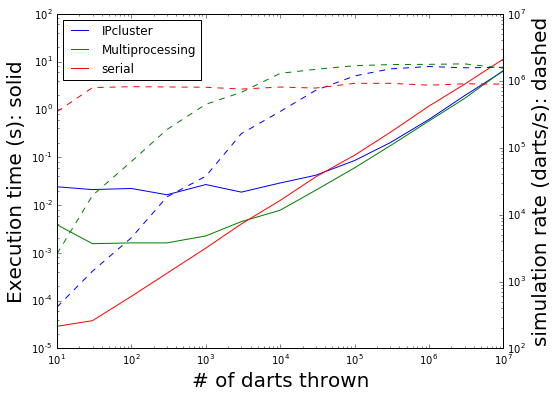

In [61]:
fs = 20
f1, ax1= plt.subplots(figsize = [8, 6])
ax1.plot(n_benchmark, t_ipp, label = 'IPcluster')
ax1.plot(n_benchmark, t_mp, label = 'Multiprocessing')
ax1.plot(n_benchmark, t_serial, label = 'serial')


ax1.set_yscale('log')
ax1.set_xscale('log')
plt.legend(loc = 'best')
ax1.set_xlabel('# of darts thrown', fontsize = fs)
ax1.set_ylabel('Execution time (s): solid', fontsize = fs)

ax2 = ax1.twinx()
n_bm_np = np.array(n_benchmark)
ax2.plot(n_benchmark, n_bm_np/np.array(t_ipp), '--')
ax2.plot(n_benchmark, n_bm_np/np.array(t_mp), '--')
ax2.plot(n_benchmark, n_bm_np/np.array(t_serial), '--')

ax2.set_yscale('log')
ax2.set_xscale('log')

ax2.set_ylabel('simulation rate (darts/s): dashed', fontsize = fs)
# for tl in ax2.get_yticklabels():
#     tl.set_color('r')
plt.show()

In [63]:
# f1.savefig('performance.png', dpi = 300)

## Result

-- hardware spec: MacBook Pro 2.6 GHz Intel Core i5, 4 cores
<img src='performance.png' />